In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import time
from IPython import display
from tensorflow.keras.utils import Sequence
from keras import backend as K
import random
'''import segmentation_models as sm
sm.set_framework('tf.keras')
import pydot
import graphviz
from keras.utils import plot_model'''


'''os.environ["KMP_BLOCKTIME"] = "1"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"
os.environ["OMP_NUM_THREADS"]= "32"
tf.config.threading.set_intra_op_parallelism_threads(32)
tf.config.threading.set_inter_op_parallelism_threads(2)'''

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


'os.environ["KMP_BLOCKTIME"] = "1"\nos.environ["KMP_SETTINGS"] = "1"\nos.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"\nos.environ["OMP_NUM_THREADS"]= "32"\ntf.config.threading.set_intra_op_parallelism_threads(32)\ntf.config.threading.set_inter_op_parallelism_threads(2)'

In [3]:
class DataGenerator(Sequence):
    def __init__(self, list_IDs,label_map , img_dir ,mode):
        'Initialization'
        self.list_IDs = list_IDs
        self.label_map = image_label_map
        self.on_epoch_end()
        self.img_dir = img_dir + "/images"
        self.mask_dir = img_dir + "/masks"
        self.mode = mode

    def __len__(self):
        return int(len(self.list_IDs))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index:(index+1)]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y    
    
    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples"""
        if self.mode == "train":
            # Generate data
            X, y = self.load_file(list_IDs_temp)
            return X, y
        elif self.mode == "val":
            X, y = self.load_file(list_IDs_temp)
            return X, y        
        
    def load_file(self, id_list):
        list_IDs_temp = id_list
        for ID in list_IDs_temp:
            x_file_path = os.path.join(self.img_dir, ID)
            y_file_path = os.path.join(self.mask_dir, self.label_map.get(ID))
            # Store sample
            X = np.load(x_file_path)
            #X = np.int64(X*255)
            # Store class
            y = np.load(y_file_path).astype('float32')
        return X, y

In [4]:
out_train_data_dir = '/home/hgamarro/DeepLearning/HG_space/data/processed/Vegas/train'
out_val_data_dir = '/home/hgamarro/DeepLearning/HG_space/data/processed/Vegas/val'


# ====================
# train set
# ====================
all_files = [s for s in os.listdir(out_train_data_dir + "/images/") if s.endswith('.npy')]
all_files.append([s for s in os.listdir(out_train_data_dir + "/masks/") if s.endswith('.npy')] )

image_label_map = {
        "image_file_{}.npy".format(i+1): "label_file_{}.npy".format(i+1)
        for i in range(int(len(all_files)))}
partition = [item for item in all_files if "image_file" in item]

# ====================
# validation set
# ====================
all_val_files = [s for s in os.listdir(out_val_data_dir + "/images/") if s.endswith('.npy')]
all_val_files.append([s for s in os.listdir(out_val_data_dir + "/masks/") if s.endswith('.npy')] )
val_image_label_map = {
        "image_file_{}.npy".format(i+1): "label_file_{}.npy".format(i+1)
        for i in range(int(len(all_val_files)))
}
val_partition = [item for item in all_val_files if "image_file" in item]


#train_generator = DataGenerator(partition,image_label_map,out_train_data_dir, "train")
#val_generator= DataGenerator(val_partition,val_image_label_map,out_val_data_dir, "val")

In [5]:
#re ,inp = load(PATH+'train/100.jpg')
#flips mask and input image
re_inp = DataGenerator(partition
                       ,image_label_map
                       ,out_train_data_dir
                       , "train")
val_re_inp= DataGenerator(val_partition
                          ,val_image_label_map
                          ,out_val_data_dir
                          , "val")

In [6]:
inp3 =  re_inp[4][1][14,:,:,:]

In [7]:
inp =  re_inp[4][0][14,:,:,:]

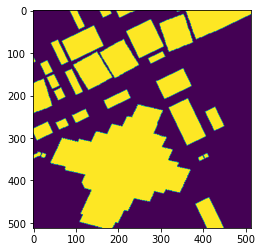

In [8]:
plt.imshow(inp3)

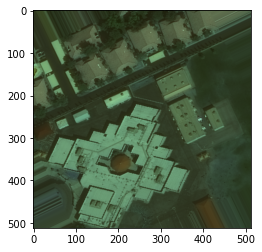

In [100]:
plt.imshow(inp)

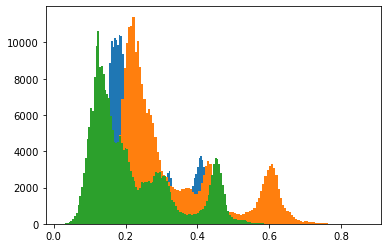

In [101]:
#fig, axes = plt.subplots(1, 3)#, figsize=(16, 5))
for a in np.arange(0,3):
    rng = inp[:,:,a]
    rng = rng.reshape(rng.shape[0]*rng.shape[1])
    plt.hist(rng, bins='auto')
    plt.show

In [102]:
type(inp)

numpy.ndarray

In [8]:
OUTPUT_CHANNELS = 1
K.clear_session()

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', 
                                      kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

model_andor_weight_path = "/home/hgamarro/DeepLearning/JB_space/models/pix2pix/"
down_model = downsample(3, 4) 
#uses mask as input

In [9]:
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)
down_model.save(model_andor_weight_path+"_down_model4.h5")
down_model.summary()

(1, 256, 256, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (1, 256, 256, 3)          144       
_________________________________________________________________
batch_normalization (BatchNo (1, 256, 256, 3)          12        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (1, 256, 256, 3)          0         
Total params: 156
Trainable params: 150
Non-trainable params: 6
_________________________________________________________________


In [10]:
K.clear_session()

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [11]:
up_model = upsample(3, 4)

In [12]:
up_result = up_model(down_result)
print (up_result.shape)
if os.path.isdir(model_andor_weight_path):
    up_model.save(model_andor_weight_path+"_up_model4.h5")

(1, 512, 512, 3)


In [13]:
K.clear_session()

def Generator():
    inputs = tf.keras.layers.Input(shape=[512, 512, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        #downsample(64, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        #upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

#Generator().summary()
generator = Generator()

In [18]:
inp.shape

(512, 512, 3)

In [32]:
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
#generator.save(model_andor_weight_path+"_generator4.h5")
gen_output = generator(inp[tf.newaxis, ...], training=False)
#gen_output = Generator_loop_mask(inp)

(1, 512, 512, 1)


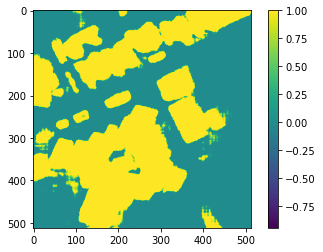

In [34]:
plt.imshow(gen_output[0, ...])
plt.colorbar()
print(gen_output.shape)

(1, 512, 512, 1)


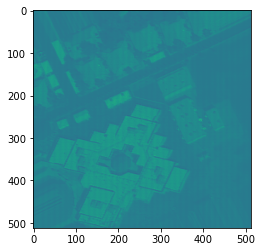

In [16]:
plt.imshow(gen_output[0, ...])
print(gen_output.shape)

(1, 512, 512, 1)


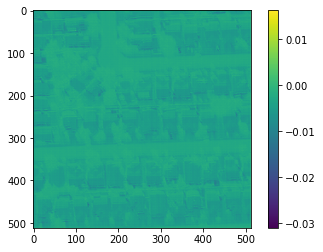

In [123]:
plt.imshow(gen_output[0, ...])
plt.colorbar()
print(gen_output.shape)

(1, 512, 512, 1)


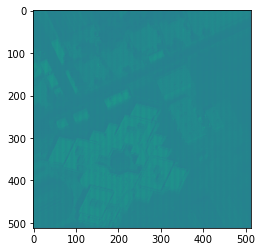

In [14]:
plt.imshow(gen_output[0, ...])
print(gen_output.shape)

In [15]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [17]:
K.clear_session()

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=(512, 512, 3), name='input_image')
    tar = tf.keras.layers.Input(shape=(512, 512, 1), name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

    down1 = downsample(128, 4, False)(x)  # (bs, 128, 128, 64)
   # down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down1)  # (bs, 128, 128, 64)
   # down4 = downsample(512, 4)(down3)  # (bs, 64, 64, 128)
   # down5 = downsample(256, 4)(down4)  # (bs, 32, 32, 256)
   # down6 = downsample(512, 4)(down5)  # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 3, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()
#tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)
#discriminator.summary()
#discriminator.save(model_andor_weight_path+"model_pix2pix_discriminator_base.h5")

In [18]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
#disc_out = discriminator([inp, gen_output], training=False)

In [21]:
disc_out.shape

TensorShape([1, 127, 127, 1])

In [22]:
inp[0][...].shape

(512, 3)

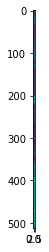

In [23]:
plt.imshow(inp[5][...])

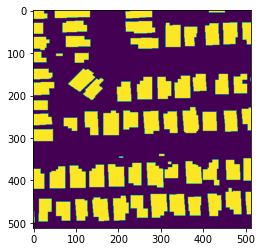

In [105]:
plt.imshow(tar[5])

(1, 127, 127, 1)


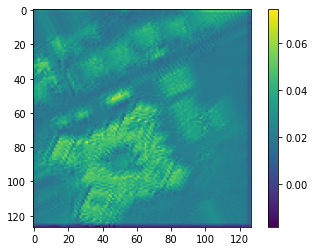

In [53]:
plt.imshow(disc_out[0, ..., -1]#, vmin=-20, vmax=20
   # , cmap='RdBu_r'
          )
plt.colorbar()
print(disc_out.shape)

In [25]:
np.histogram(disc_out)

(array([   8,   83,  468, 2063, 9427, 2951,  782,  223,   98,   26]),
 array([-0.02757239, -0.02105529, -0.01453819, -0.00802109, -0.001504  ,
         0.0050131 ,  0.0115302 ,  0.0180473 ,  0.0245644 ,  0.0310815 ,
         0.0375986 ], dtype=float32))

(1, 127, 127, 1)


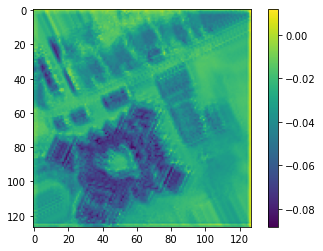

In [50]:
plt.imshow(disc_out[0, ..., -1]#, vmin=-20, vmax=20
   # , cmap='RdBu_r'
          )
plt.colorbar()
print(disc_out.shape)
#this is trained

In [ ]:
np.histogram(disc_out)

(1, 127, 127, 1)


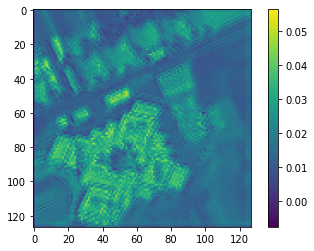

In [68]:
plt.imshow(disc_out[0, ..., -1]#, vmin=-20, vmax=20
   # , cmap='RdBu_r'
          )
plt.colorbar()
print(disc_out.shape)

In [19]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [28]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [20]:
def IOUscore(tar ,pred):
    bool_tar = np.array(test_mask ,dtype=bool)
    bool_pred = np.array(tf.math.greater(pred ,.5))
    #bool_pred = np.array(tf.math.greater(pred ,.5))
    
    intersection = bool_tar * bool_pred
    union = bool_tar + bool_pred
    print(intersection.sum() / union.sum())
    return intersection.sum() / union.sum()

In [21]:
def IOUscore(tar ,pred):
    bool_tar =tf.boolean_mask(tar)
    bool_pred = tf.math.greater(pred ,.5)
    #bool_pred = np.array(tf.math.greater(pred ,.5))
    
    intersection = tf.math.multiply(bool_tar,bool_pred)
    union = tf.math.add(bool_tar + bool_pred)
    print(intersection.sum() / union.sum())
    return intersection.sum() / union.sum()

In [22]:
model_andor_weight_path = "/home/hgamarro/DeepLearning/JB_space/models/pix2pix/"
checkpoint_dir = model_andor_weight_path+'logs/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
log_dir=model_andor_weight_path+"logs/"
summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

In [23]:
def generate_images(model, test_input, tar ,epoch):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']   
        
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()
    
    #iou_score = IOUscore(test_input ,prediction)

    '''with summary_writer.as_default():
        tf.summary.scalar('iou_score', iou_score, step=epoch)'''

In [142]:
i=random.randint(0,91-1)
j=random.randint(0,20-1)
pred = generator(val_re_inp[i][0][tf.newaxis ,j,...], training=True)
pred = pred[0]
test_inp = val_re_inp[i][0][j ,...]
test_mask =  val_re_inp[i][1][j ,...]
print(test_inp.shape ,test_mask.shape ,pred.shape )
#print(type(test_inp) ,type(test_mask) ,type(pred) )

(512, 512, 3) (512, 512, 1) (512, 512, 1)


bool_tar =tf.boolean_mask(test_inp ,np.array(test_inp ,dtype=bool))
bool_pred = tf.math.greater(test_mask ,.5)
#bool_pred = np.array(tf.math.greater(pred ,.5))

intersection = tf.math.multiply(bool_tar,bool_pred)
#intersection = tf.(bool_tar,bool_pred)
union = tf.math.add(bool_tar , bool_pred)
sum_i = tf.reduce_sum(intersection) 
sum_u = tf.reduce_sum(union)
return tf.math.divide(sum_i , sum_u)

#intersection = tf.(bool_tar,bool_pred)
union = tf.math.add(bool_tar , bool_pred)
sum_i = tf.reduce_sum(intersection) 
sum_u = tf.reduce_sum(union)
return tf.math.divide(sum_i , sum_u)

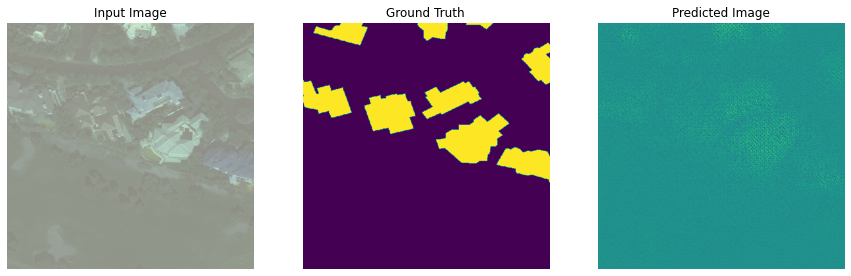

InvalidArgumentError: Value for attr 'T' of bool is not in the list of allowed values: bfloat16, half, float, double, uint8, int8, uint16, int16, int32, uint32, uint64, int64, complex64, complex128
	; NodeDef: {{node Mul}}; Op<name=Mul; signature=x:T, y:T -> z:T; attr=T:type,allowed=[DT_BFLOAT16, DT_HALF, DT_FLOAT, DT_DOUBLE, DT_UINT8, DT_INT8, DT_UINT16, DT_INT16, DT_INT32, DT_UINT32, DT_UINT64, DT_INT64, DT_COMPLEX64, DT_COMPLEX128]; is_commutative=true> [Op:Mul]

In [145]:
generate_images( generator
               # ,tf.cast(test_ds[i][0][tf.newaxis ,j,:,:,:], tf.float32)
                #,tf.cast(test_ds[i][1][tf.newaxis ,j,:,:,:], tf.float32)
                ,val_re_inp[i][0][tf.newaxis ,j ,...]
                ,val_re_inp[i][1][tf.newaxis ,j ,...]
               ,1) 

In [124]:
np.histogram(test_inp)

(array([ 29540, 317335, 211593, 103210,  47962,  30587,  21776,   9174,
         12122,   3133]),
 array([0.        , 0.09294118, 0.18588236, 0.27882352, 0.37176472,
        0.46470588, 0.55764705, 0.6505882 , 0.74352944, 0.8364706 ,
        0.92941177], dtype=float32))

In [125]:
np.histogram(test_mask)

(array([176777,      0,      0,      0,      0,      0,      0,      0,
             0,  85367]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32))

In [126]:
np.histogram(pred)

(array([  520,  2231,  7102, 27773, 79000, 90143, 39927, 10527,  3692,
         1229]),
 array([-0.977263  , -0.78312707, -0.58899117, -0.39485523, -0.20071931,
        -0.00658339,  0.18755253,  0.38168845,  0.5758244 ,  0.7699603 ,
         0.9640962 ], dtype=float32))

In [83]:
type(test_mask)

numpy.ndarray

In [84]:
type(pred)

tensorflow.python.framework.ops.EagerTensor

In [44]:
test_mask.shape

(512, 512, 1)

In [85]:
bool_mask = np.array(test_mask ,dtype=bool)
np.histogram( bool_mask )

(array([261654,      0,      0,      0,      0,      0,      0,      0,
             0,    490]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [86]:
bool_mask.shape

(512, 512, 1)

In [87]:
bool_pred = np.array(tf.math.greater(pred ,.5))
np.histogram( bool_mask )

(array([261654,      0,      0,      0,      0,      0,      0,      0,
             0,    490]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [88]:
bool_pred.shape

(512, 512, 1)

In [89]:
pred.shape

TensorShape([512, 512, 1])

In [50]:
np.histogram( np.array(bool_pred ,dtype=bool) )

(array([260051,      0,      0,      0,      0,      0,      0,      0,
             0,   2093]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [52]:
intersection = bool_mask * bool_pred
union = bool_mask + bool_pred
IOU = intersection.sum() / union.sum()
IOU

0.019285617275567025

In [53]:
test_dataset = re_inp[0][0][0,:,:,:]

In [54]:
for i in np.arange(len(re_inp) -90):
    for j in np.arange(re_inp[i][0][:,:,:,:].shape[0] -31):
        print( re_inp[i][1][j,:,:,:].shape)
        print( re_inp[i][0][j,:,:,:].shape)

(512, 512, 1)
(512, 512, 3)


In [55]:
inp3.shape

(512, 512, 1)

In [56]:
for i in np.arange(len(re_inp) -90):
    for j in np.arange(re_inp[i][0][:,:,:,:].shape[0] -31):
        generate_images( generator
                        , re_inp[i+52][0][tf.newaxis ,j,:,:,:]
                        , re_inp[i+52][1][tf.newaxis ,j,:,:,:]
                       ,)
        #print(re_inp[i][1][tf.newaxis ,j,:,:,:]).shape

TypeError: generate_images() missing 1 required positional argument: 'epoch'

In [29]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [24]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        #print(gen_output.shape)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

trainstep = train_step(re_inp[0][0][np.newaxis ,1,...] ,re_inp[0][1][np.newaxis ,1,...] ,1)
type(trainstep)
del trainstep

#this actually works to train
for input_image, target in zip(re_inp[i][0][tf.newaxis ,j,:,:,:]
                            ,re_inp[i][1][tf.newaxis ,j,:,:,:]):
    print(input_image.shape)
    print(type(input_image))
    print(target.shape)
    print(type(tf.cast(target, tf.float32)))
    train_step(tf.cast(input_image[tf.newaxis ,...] , tf.float32)
               , tf.cast(target[tf.newaxis ,...], tf.float32)
               , epoch=1
              )

if not os.path.isfile(model_andor_weight_path+"model_pix2pix_generator_trained2.h5"):
	generator.save(model_andor_weight_path+"model_pix2pix_generator_trained2.h5")
if not os.path.isfile(model_andor_weight_path+"model_pix2pix_discriminator_trained2.h5"):
	discriminator.save(model_andor_weight_path+"model_pix2pix_discriminator_trained2.h5")

In [39]:
print("val_re_inp/test_ds len: " ,len(val_re_inp))

val_re_inp/test_ds len:  23


In [40]:
datetime.now() - datetime.now()

datetime.timedelta(days=-1, seconds=86399, microseconds=999998)

In [41]:
print(re_inp[0][0][:,:,:,:].shape[0])
print(len(re_inp))

32
91


In [42]:

bs2 = re_inp[0][0][:,:,:,:].shape[0]
bs1 = len(re_inp)
for batch in [85]:     
    for row in range( re_inp[batch][0][...].shape[0] ):
        #if (row >9) & (row < 13):
        print(batch ,"," ,row)
        print( re_inp[batch][0][row,...].shape[0]
                             #,len(train_ds)[1].shape
             )
        
'''for inp_mask in train_ds:
    for batch in zip(inp_mask[0] , inp_mask[1]):
        print('.', end='')'''
        

85 , 0
512
85 , 1
512
85 , 2
512
85 , 3
512
85 , 4
512
85 , 5
512
85 , 6
512
85 , 7
512
85 , 8
512
85 , 9
512
85 , 10
512


"for inp_mask in train_ds:\n    for batch in zip(inp_mask[0] , inp_mask[1]):\n        print('.', end='')"

In [60]:
def Fit(train_ds, epochs, test_ds):
    #bs2 = train_ds[0][0][:,:,:,:].shape[0]
    bs1 = len(train_ds)
    '''bs2_ = test_ds[0][0][:,:,:,:].shape[0]
    bs1_ = len(test_ds)'''
    
    for epoch in range(epochs):
        #start1 = time.time()
        start = datetime.now()
        print("start: " ,start)
        
        for batch in range( bs1 ):        
            for row in range( train_ds[batch][0][...].shape[0] ):
                print('.' , row , end='')
                img_masks = (train_ds[batch][0][row,...] 
                             ,train_ds[batch][1][row,...])
                if (epoch) % 1 == 0:                
                    train_step( epoch=epoch
                               , input_image = img_masks[0][tf.newaxis ,...]
                               , target = img_masks[1][tf.newaxis ,...]
                                        )
           
            print("-finished a training batch-"+str(epoch+1)+"_"+str(batch+1) ,'-' ,datetime.now() , end='\n')
            
            '''i=random.randint(0,bs1_)
            j=random.randint(0,bs2_)
            generate_images( generator
                            ,test_ds[i][0][tf.newaxis ,j,:,:,:]
                            ,test_ds[i][1][tf.newaxis ,j,:,:,:]''' 
            if batch % 45 == 0:
            #if (epoch+1) % 10 == 0:
                checkpoint.save(file_prefix=checkpoint_prefix+'_epoch_batch:'+str(epoch+1)+"_"+str(batch+1) )
            #print("\n---------------------------------------------Epoch: ", epoch)

        end = datetime.now()
        print("end: " ,end='\n')
        print("\nTime Taken for epoch: %s" % (end-start))
           
        checkpoint.save(file_prefix=checkpoint_prefix+'_epoch_batch:'+str(epoch+1)+"_"+str(batch+1) )

    # saving (checkpoint) the model every 20 epochs
    #if (epoch + 1) % 2 == 0:
        #checkpoint.save(file_prefix=checkpoint_prefix)

In [40]:
EPOCHS = 2
Fit(re_inp
    , EPOCHS
    , val_re_inp)

start:  2021-05-12 09:45:26.680133
. 0. 1. 2. 3. 4

KeyboardInterrupt: 

In [ ]:
sum_iou = []
for example_input, example_target in test_ds.take(len(test_ds)):
    prediction = generator(example_input, training=False )

    metrics.update_state(example_target,prediction , sample_weight=None)
    sum_iou.append(metrics.result().numpy())
    metrics.reset_states()

iou_average = np.average(sum_iou)

In [ ]:
for epoch in range(10):
    print(epoch+1)

In [65]:
def IOUscore(tar ,pred):    
    bool_tar = np.array(tar ,dtype=bool)
    bool_pred = np.array(tf.math.greater(pred ,.5))
    #bool_pred = np.array(tf.math.greater(pred ,.5))
    
    intersection = bool_tar * bool_pred
    union = bool_tar + bool_pred
    return intersection.sum() / union.sum()

In [66]:
start = datetime.now()

sum_iou = []
cnt = 0
#for example_input, example_target in test_dataset.take(10
for inp ,tar in val_re_inp:
    for example_input ,example_target in zip(inp,tar):
        prediction = generator(example_input[tf.newaxis ,...], training=False )
        iou_score = IOUscore(example_target ,prediction)
        if cnt/100 == 0:
            print(cnt ,datetime.now())
        sum_iou.append(iou_score)
        cnt = cnt+1

iou_average = np.average(sum_iou)

end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))

0 2021-05-13 01:41:06.647069

Time Taken for testing: 0:01:55.735863


In [67]:
iou_average

0.6169516412172307

In [ ]:
re_inp[0][1].shape

In [ ]:
for epoch in range(150):
    bs2 = re_inp[0][0][:,:,:,:].shape[0]
    bs1 = len(re_inp)

    for batch in range(bs1-1):        
        for row in range(bs2-1):
            img_masks = (re_inp[batch][0][row,...] 
                         ,re_inp[batch][1][row,...])
            if (epoch) % 1 == 0:                
                print(img_masks[0].shape)
                print(img_masks[1].shape)
                print(batch)
                print(row)
                generate_images(model = generator
                                ,test_input = img_masks[0][tf.newaxis ,...]
                                ,tar = img_masks[1][tf.newaxis ,...]
                               )

In [134]:
checkpoint_dir

'/home/hgamarro/DeepLearning/JB_space/models/pix2pix/logs/training_checkpoints'

In [30]:
checkpoint.restore(tf.train.latest_checkpoint('/home/hgamarro/DeepLearning/JB_space/models/pix2pix/logs0510/training_checkpoints'))

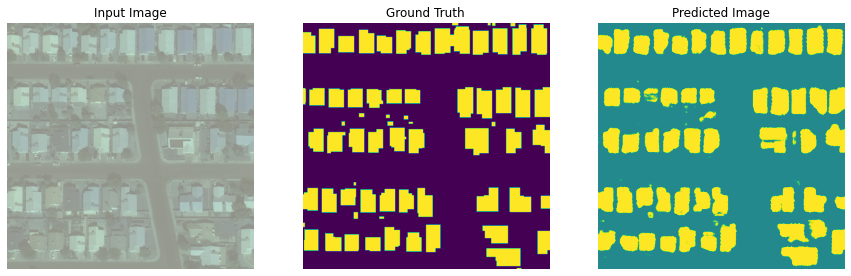

TensorShape([1, 512, 512, 1])

In [35]:
bs2 = val_re_inp[0][0][:,:,:,:].shape[0]
bs1 = len(val_re_inp)

i=random.randint(0,bs1-1)
j=random.randint(0,bs2-1)
generate_images( generator
               # ,tf.cast(test_ds[i][0][tf.newaxis ,j,:,:,:], tf.float32)
                #,tf.cast(test_ds[i][1][tf.newaxis ,j,:,:,:], tf.float32)
                ,val_re_inp[i][0][tf.newaxis ,j,...]
                ,val_re_inp[i][1][tf.newaxis ,j,...]
                 ,0 
                ) 
pred = generator(val_re_inp[i][0][tf.newaxis ,j,...], training=False)
pred.shape

In [63]:
np.histogram(pred[0])

(array([    12,     14,     55,    124, 250398,    993,    364,    309,
           342,   9533]),
 array([-0.97242564, -0.7751831 , -0.5779405 , -0.38069794, -0.18345538,
         0.01378718,  0.21102974,  0.4082723 ,  0.6055149 ,  0.80275744,
         1.        ], dtype=float32))

In [56]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [18]:
%tensorboard --logdir '/home/hgamarro/DeepLearning/JB_space/models/pix2pix/logs0507/fit/'

In [35]:
os.getcwd()

'/home/hgamarro/DeepLearning/JB_space/notebooks/scratch'

In [ ]:
#warnings.filterwarnings(action="ignore" ,category=UserWarning)

# Extracts the outputs starting at x layer
x_layers = 20 #56
x_range = 15
layer_names = []
for layer in activation_model.layers[x_layers:x_layers+x_range]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, temp_pred[x_layers:x_layers+x_range]): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    '''print("\n1~activation_shape " ,layer_activation.shape)
    print("n_features " ,n_features)
    print("size " ,size)
    print("n_cols " ,n_cols)
    print("display_grid " ,size * n_cols ," ; " ,images_per_row * size)
    print("2~layername " ,layer_name)'''
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            '''channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            #channel_image /= channel_image.std()
            channel_image *= 3
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')'''
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 3. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name,fontsize=50)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto' #,cmap='viridis'
              )

#warnings.filterwarnings(action='default')